# Programming Assignment No. 4: Support Vector Machines (SVM)

---

## Preparation

Import the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel

Load the dataset.

In [2]:
# X contains features, while y contains labels
data = load_breast_cancer()
x, y = data.data, data.target

We reduced the dimensionality of the features to only contain the mean values. This significantly reduces training time, inference time, and memory. We can also easily perform exploratory data analysis with less features that can convolute the process.

In [3]:
# Index the dataset
x = x[:, :10]

## Exploratory Data Analysis

To perform EDA, we have to change x from an `numpy.ndarray` to a `pandas.DataFrame` with the proper feature names to visualize it better.

In [4]:
x_df = pd.DataFrame(x, columns=data.feature_names[:10])
x_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


Let's see if there are any missing values.

In [5]:
x_df.isnull().sum()

mean radius               0
mean texture              0
mean perimeter            0
mean area                 0
mean smoothness           0
mean compactness          0
mean concavity            0
mean concave points       0
mean symmetry             0
mean fractal dimension    0
dtype: int64

We already have trained a logistic regression model using this breast cancer dataset. The same EDA should apply since we are performing the same task in the same dataset. A pairplot will produce 100 plots in total which can get really large and intractable. Therefore, we used a heatmap to show the correlation among the variables numerically.

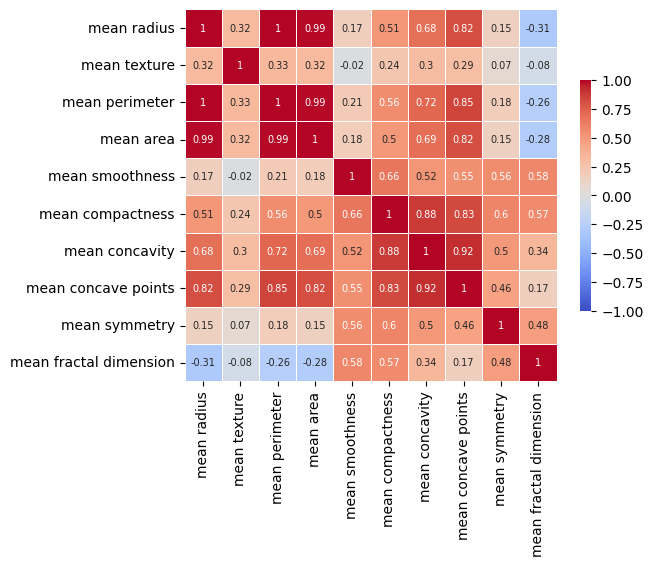

In [6]:
def heatmap(x):
  corr = x.corr().round(2)
  f, ax = plt.subplots(figsize=(6, 6))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"fontsize":7})
  plt.show()

heatmap(x_df)

From here, we can see some highly linear correlations among the features. The problem of multicollinearity may arise which will hurt the effectiveness of any model that we may use. It is in our best interest to remove some of those features. It should be obvious by now that radius, perimeter, and area are highly collinear with each other. We're keeping the radius parameter since it essentially gives us both the perimeter and area features. Moreover, we can arbitrarily say that concavity, symmetry, and compactness are highly collinear with each other. From there, we can argue that these features should also be removed.

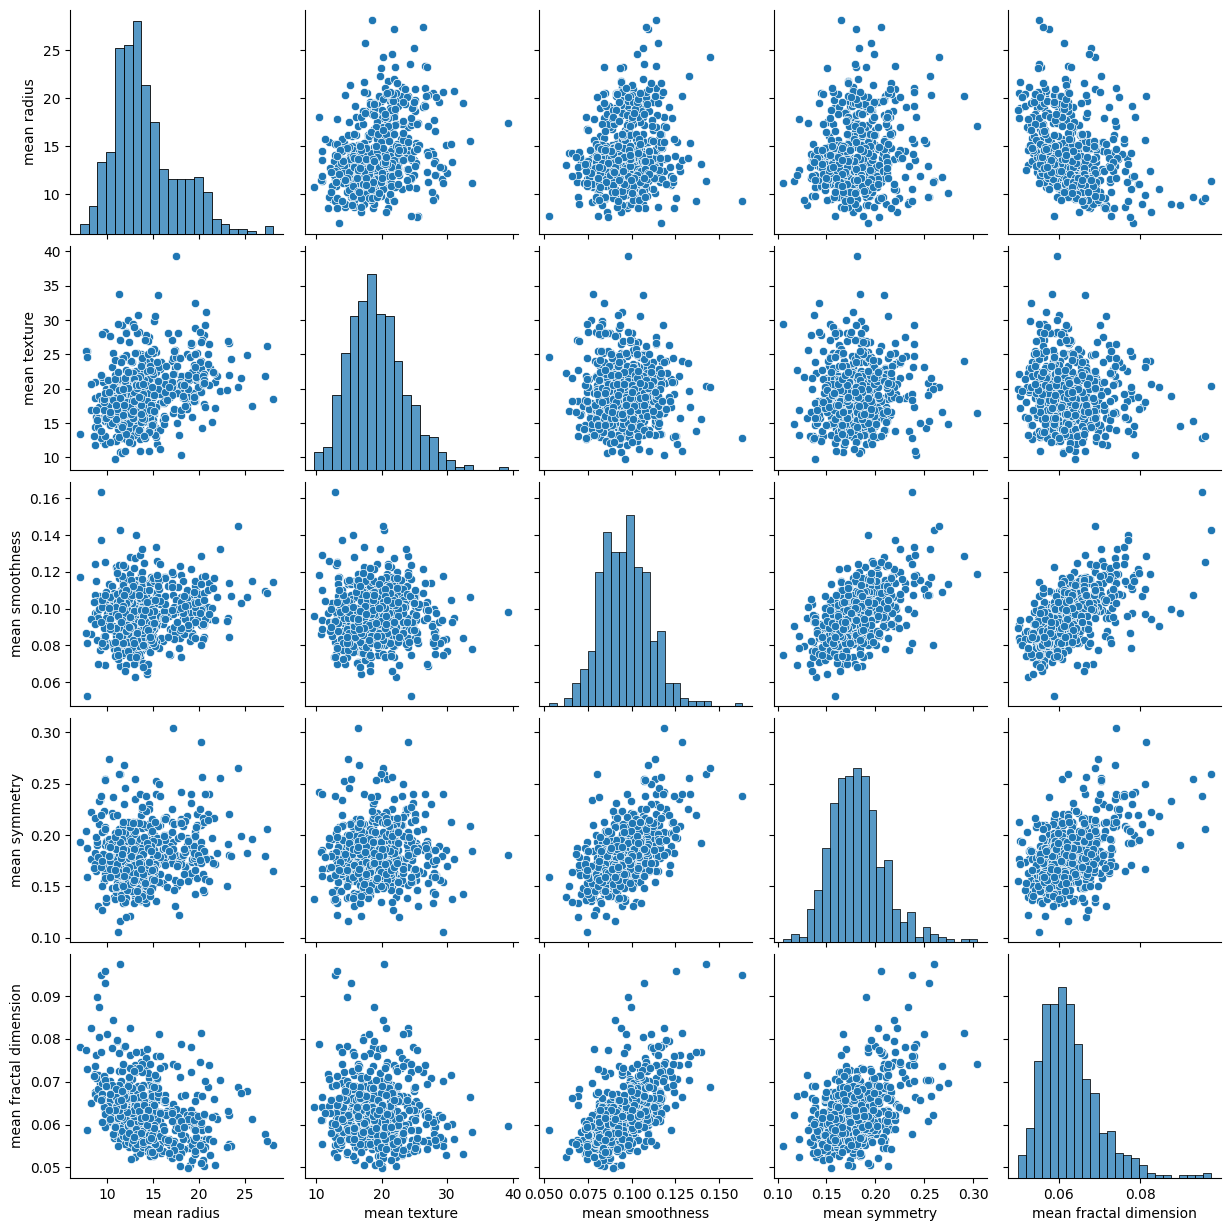

In [7]:
r = x_df.iloc[:, [0, 1, 4, 8, 9]]
sns.pairplot(r);

With reduced number of features, we can now use `sns.pairplot` to see any trends among the chosen features. We can also see that the values are distributed in a Gaussian distribution. We can use the `StandardScaler` to normalize this distribution for better training stability.

In [8]:
x = r.to_numpy()
x.shape

(569, 5)

## Model Training and Evaluation

Split the dataset into 70% training and 30% testing sets. We stratified across the labels to make sure there are enough data points for both labels.

In [9]:
# Stratify the dataset across y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

Normalize the feature values using `StandardScaler`.

In [10]:
# Normalize features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Train the Support Vector Classifier with the default parameters.

In [11]:
# Fit model
svm = SVC()
svm.fit(x_train, y_train)

SVC()

From the given evaluation metrics, we can see that there seems to be overfitting. The testing accuracy is too far from the training accuracy which may need a bit of regularization to fix.

In [12]:
# Evaluate initial model
train_acc = accuracy_score(y_train, svm.predict(x_train))
test_acc = accuracy_score(y_test, svm.predict(x_test))
print(f"Initial Training Accuracy: {train_acc:.4f}")
print(f"Initial Testing Accuracy: {test_acc:.4f}")

Initial Training Accuracy: 0.9623
Initial Testing Accuracy: 0.9123


Let's use `GridSearchCV` to determine the optimal hyperparameters. We will be doing this manually unlike AutoML algorithms that have RL trained neural networks that automatically finds the best hyperparameters.

In [13]:
from sklearn.model_selection import StratifiedKFold

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(SVC(), param_grid, cv=stkfold, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Best parameters and retraining
best_svm = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
best_svm.fit(x_train, y_train)

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


SVC(C=10, gamma=0.1)

In [14]:
# Final evaluation
train_acc = accuracy_score(y_train, best_svm.predict(x_train))
test_acc = accuracy_score(y_test, best_svm.predict(x_test))
print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Testing Accuracy: {test_acc:.4f}")

Final Training Accuracy: 0.9698
Final Testing Accuracy: 0.9123


The training accuracy of this model is 0.007 higher than the model with the default parameters. But the testing accuracy is still too far from the training accuracy. This is probably because we overfitted in the validation set. We can use our domain knowledge to fix this. Sometimes, having computational resources doesn't guarantee that you'll arrive with the best model. You still have to use your domain knowledge to solve problems like this. Here, we will increase the regularization parameter to control overfitting.

In [15]:
custom_svm = SVC(kernel='rbf', C=0.1)
custom_svm.fit(x_train, y_train)

train_acc = accuracy_score(y_train, custom_svm.predict(x_train))
test_acc = accuracy_score(y_test, custom_svm.predict(x_test))
print(f"Initial Training Accuracy: {train_acc:.4f}")
print(f"Initial Testing Accuracy: {test_acc:.4f}")

Initial Training Accuracy: 0.9271
Initial Testing Accuracy: 0.9357


As we can see, we have a <b>much lower training accuracy but a higher testing accuracy</b>. 

In [16]:
def evaluate_model(model):
    # Confusion matrix and classification metrics
    y_pred = model.predict(x_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Extract precision, recall, F1-score, and false alarm rate
    TN, FP, FN, TP = conf_matrix.ravel()
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    false_alarm_rate = FP / (FP + TN)
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}")
    print(f"False Alarm Rate: {false_alarm_rate:.4f}")

evaluate_model(best_svm)

Confusion Matrix:
 [[59  5]
 [10 97]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89        64
           1       0.95      0.91      0.93       107

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.92      0.91      0.91       171

Precision: 0.9510
Recall: 0.9065
F1-score: 0.9282
False Alarm Rate: 0.0781


In [17]:
evaluate_model(custom_svm)

Confusion Matrix:
 [[ 58   6]
 [  5 102]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91        64
           1       0.94      0.95      0.95       107

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171

Precision: 0.9444
Recall: 0.9533
F1-score: 0.9488
False Alarm Rate: 0.0938


We can see a much higher <b>recall</b> which is a good metric for detecting tumor malignancy and a good <b>F1-score</b>.

## Guide Questions

1. How did you preprocess the dataset (feature scaling, handling missing values if any, etc.)?

In preprocessing the data, I used a heatmap do determine the correlation among the feature vectors. If two or more feature vectors are said to be collinear with each other, there are several implications. There can be numerical instability, redundancy which may reinforce weak patterns, etc. Think of it as having a 3x3 matrix and the two rows are collinear (or linearly dependent), then the rank of that matrix is 2. So if the correlation coefficient between two (2) or more features is high, I opted remove it. Additionally, we checked the distribution of the features and we normalized it using `StandardScaler`. There aren't any missing values so we just created a pairplot to see any correlations among the chosen features.

2. Why is it necessary to split the dataset into training and testing sets?

It is necessary to split the training and testing sets for any supervised machine learning task to properly evaluate the model to a siloed dataset. Without splitting the dataset, we don't have any way to benchmark our results from the hyperparameter search or model selection that we did. It is critical that the model can't absolutely see the testing set while training because it might pick up some patterns from the testing set.

3. What is the role of StandardScaler in SVM training?

StandardScaler is mostly for numerical stability. SVM calculates the distance between data points to determine the support vectors and separate the space using hyperplanes. This process involves dot product and if some features have higher-valued data, it will dominate the calculations. `StandardScaler` normalizes the data by setting the mean to 0 and the variance/standard deviation to 1. This means that the feature values are on the same scale.

4. How does C affect the performance of an SVM model?

C is a regularization parameter. According to the documentation, the higher the C, the less the regularization. Regularization is a machine learning technique that reduces the model complexity which avoids overfitting. A higher C means that the model will likely to overfit the training data and perform poorly in the testing data. This is evident in the grid search and default training that we did. By lowering the C parameter, we are essentially restricting the model from overfitting. If C is too low, the model may not be able to extract patterns from the training data because it is essentially jailed.

5. What is the purpose of the kernel function in SVM?

The kernel in SVM places the features in a higher dimension which is then flattened to a 2D decision boundary. Different kernels produce different kinds of spatial transformation.

6. What were the best hyperparameters found using GridSearchCV?

The best hyperparameters found using `GridSearchCV` is C=10, gamma=0.1, kernel=rbf. However, there seems to be a high presence of overfitting because the testing accuracy is much lower than the training accuracy.

7. What is a confusion matrix, and how is it interpreted?

Confusion matrix shows the correctly and incorrectly predicted class labels for classification tasks. It allows us to calculate different evaluation metrics including precision, recall, F1-score, and false alarm rate. (0,0) and (1,1) are the correctly classified classes, these can be extended depending on how many classes there are. (0,1) is false positive or Type I error in statistical terms while (1,0) is false negative or Type II error. Remember that the error classification is dependent on which label is "positive" for you, this is a different case for multi-class classification.

8. How are Precision, Recall, and F1-score calculated from the confusion matrix?

The calculations for each metric is as follows:

```
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    false_alarm_rate = FP / (FP + TN) 
```
9. If the model does not perform well, what adjustments can be made to improve it?

If the model doesn't perform well we can do many things. First is to gather more data, in this case, this takes too much time. Next is to look at the evaluation metrics and find if there is overfitting or underfitting. If there is, we can increase the regularization or reduce model complexity, use a different set of hyperparameters, or preprocess the dataset better.